# import

In [5]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pylab as plt
import requests
import json
from matplotlib import font_manager, rc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 속성추가 : 지번주소, 면적당금액
* 자치구명, 법정동명, 지번코드를 사용하여 지번주소를 만듭니다
* (물건금액 / 건물면적)으로 면적당금액을 구합니다

In [6]:
org_df = pd.read_csv('datas/input/download/서울특별시 부동산 실거래가 정보.csv')
use_df = org_df[org_df['신고년도'].isin([2017, 2018, 2019])][
        [
            '실거래가아이디',
            '지번코드',
            '자치구명',
            '법정동명',
            '신고년도',
            '건물면적',
            '층정보',
            '물건금액',
            '건축년도',
            '건물주용도'
        ]
]
use_df['면적당금액'] = use_df['물건금액'] / use_df['건물면적']
use_df = use_df.astype('str')
use_df = use_df[use_df['지번코드'].str.len() == 19]

def to_address(s):
    a = s.지번코드[-8:-4].lstrip('0')
    b = s.지번코드[-4:].lstrip('0')
    addr = f'서울특별시 {s.자치구명} {s.법정동명} '
    addr += f'{a} - {b}' if b else a
    return addr

use_df['지번주소'] = use_df.apply(to_address, axis=1)
use_df.head(2)

,실거래가아이디,지번코드,자치구명,법정동명,신고년도,건물면적,층정보,물건금액,건축년도,건물주용도,면적당금액,지번주소
0,11110-2019-4-0003026-1,1111017900101990000,종로구,홍파동,2019,84.93,5.0,1505000000,2017.0,아파트,17720475.685858943,서울특별시 종로구 홍파동 199
1,11110-2019-4-0003296-1,1111018000101260000,종로구,교북동,2019,45.88,8.0,970000000,2017.0,아파트,21142109.85178727,서울특별시 종로구 교북동 126


# 속성추가 : x, y
* Kakao API를 사용하여 지번주소를 x, y로 변환합니다
* API로 중복된 주소를 요청하지 않게 unique한 주소만 준비합니다

In [ ]:
need_xy_h = pd.DataFrame(use_df['지번주소'].unique(), columns=['지번주소'])
need_xy_h.head()

# input: 지번주소, output: (x,y)
def get_xy(address):
    url = 'https://dapi.kakao.com/v2/local/search/address'
    queryString = {'query': address}
    header = {'authorization': 'KakaoAK 6c278df812d9e7f9186d188ae00ca25e'}
    r = requests.get(url, headers=header, params=queryString)
    if r.status_code != 200:
        print('리스폰 오류')
        df.to_csv('output/매칭 좌표.csv', encoding='euc-kr')
        raise Exception('리스폰 오류')
    try:
        addr = json.loads(r.text)['documents'][0]['address']
        return (addr['x'], addr['y'])
    except:
        return None, None


# 오래걸리므로 실행하지 않습니다 (약 30분 소요)
# 이후 단계는 저장해둔 파일로 진행합니다
'''
need_xy_h['x'], need_xy_h['y'] = 0, 0
for i in range(len(need_xy_h)):
    x, y = get_xy(need_xy_h.iloc[i]['지번주소'])
    need_xy_h['x'][i] = x
    need_xy_h['y'][i] = y
need_xy_h.to_csv('datas/input/made/매칭 좌표.csv', encoding='euc-kr')
'''

# csv에 저장된 API결과를 불러옵니다

In [7]:
xy_house = pd.read_csv('datas/input/made/3_매칭 좌표.csv', encoding='cp949',
                      usecols=['지번주소', 'x', 'y'])
xy_house.head(2)

,지번주소,x,y
0,서울특별시 종로구 홍파동 199,126.963610,37.570697
1,서울특별시 종로구 교북동 126,126.961395,37.571579


# 지번주소와 좌표를 merge합니다

In [8]:
use_df = use_df.merge(xy_house, on='지번주소')
use_df.head(2)

,실거래가아이디,지번코드,자치구명,법정동명,신고년도,건물면적,층정보,물건금액,건축년도,건물주용도,면적당금액,지번주소,x,y
0,11110-2019-4-0003026-1,1111017900101990000,종로구,홍파동,2019,84.93,5.0,1505000000,2017.0,아파트,17720475.685858943,서울특별시 종로구 홍파동 199,126.96361,37.570697
1,11110-2019-4-0003850-1,1111017900101990000,종로구,홍파동,2019,84.94,16.0,1540000000,2017.0,아파트,18130445.02001413,서울특별시 종로구 홍파동 199,126.96361,37.570697


# (역정보, 좌표정보)csv 파일을 merge합니다
* 공통 속성인 전철역코드를 기준으로 merge합니다

In [9]:
sc_df = pd.read_csv('datas/input/download/서울시 역코드로 지하철역 위치 조회.csv',
                        usecols=['전철역코드', 'X좌표(WGS)', 'Y좌표(WGS)']).astype(str)
ss_df = pd.read_csv('datas/input/download/서울특별시 노선별 지하철역 정보.csv',
                        usecols=['전철역코드', '전철역명']).astype(str)

sc_df['전철역코드'] = sc_df['전철역코드'].apply(lambda x: x.lstrip('0'))
ss_df['전철역코드'] = ss_df['전철역코드'].apply(lambda x: x.lstrip('0'))
xy_station = pd.merge(ss_df, sc_df, on='전철역코드').dropna()
xy_station.columns = ['전철역코드', '전철역명', 'y', 'x']
xy_station.head(2)

,전철역코드,전철역명,y,x
0,1026,구룡,37.486839,127.058856
1,1208,덕소,37.586781,127.208832


# 속성추가 : 최단역명, 최단역겨리
1. 모든역과의 거리를 피타고라스 공식으로 구합니다
2. 가장 가까운 거리를 찾습니다

In [11]:
def find_nearest(s):
    x_sq = pow(xy_station['x'] - s.x, 2)
    y_sq = pow(xy_station['y'] - s.y, 2)
    xy = x_sq + y_sq
    xy_root = pow(xy, 0.5)
    idxmin = xy_root.idxmin()
    return xy_station.iloc[idxmin]['전철역명'], xy_root.iloc[idxmin]

# 오래걸리므로 실행하지 않습니다.
# 이후 단계는 저장해놓은 파일을 사용합니다
'''
use_df.dropna(inplace=True)
use_df['x'] = use_df['x'].astype('float')
use_df['y'] = use_df['y'].astype('float')
xy_station['x'] = xy_station['x'].astype('float')
xy_station['y'] = xy_station['y'].astype('float')

use_df['최단역명'], use_df['최단역거리'] = zip(*use_df.apply(find_nearest, axis=1))
use_df.to_csv('datas/input/made/최단역 추가.csv', encoding='euc-kr')
'''

use_df = pd.read_csv('datas/input/made/최단역 추가.csv', encoding='cp949').iloc[:, 1:]
use_df.head(2)

"\nuse_df.dropna(inplace=True)\nuse_df['x'] = use_df['x'].astype('float')\nuse_df['y'] = use_df['y'].astype('float')\nxy_station['x'] = xy_station['x'].astype('float')\nxy_station['y'] = xy_station['y'].astype('float')\n\nuse_df['최단역명'], use_df['최단역거리'] = zip(*use_df.apply(find_nearest, axis=1))\nuse_df.to_csv('datas/input/made/최단역 추가.csv', encoding='euc-kr')\n"

C:\Users\Minji\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,실거래가아이디,지번코드,자치구명,법정동명,신고년도,건물면적,층정보,물건금액,건축년도,건물주용도,면적당금액,지번주소,x,y,최단역명,최단역거리
0,11110-2019-4-0003026-1,1111017900101990000,종로구,홍파동,2019,84.93,5.0,1505000000,2017.0,아파트,1.772048e+07,서울특별시 종로구 홍파동 199,126.96361,37.570697,서대문,0.005782
1,11110-2019-4-0003850-1,1111017900101990000,종로구,홍파동,2019,84.94,16.0,1540000000,2017.0,아파트,1.813045e+07,서울특별시 종로구 홍파동 199,126.96361,37.570697,서대문,0.005782


# 지역별로 상관계수를 봅니다
* 면적당금액, 최단역거리의 상관계수입니다
* 상관계수가 -1 또는 1에 가까운 극단적인 지역은 데이터수가 적어 신뢰도가 낮습니다

,데이터수,상관계수,전철역명
247,5,-0.873114,학여울
214,71,-0.805424,응봉
222,11,-0.766616,잠원
139,110,-0.759387,선릉
4,29,-0.745817,강남
254,163,-0.732390,행당
179,73,-0.718155,압구정
19,4,-0.699751,고속터미널
242,7,-0.697786,충무로
154,42,-0.652561,신내


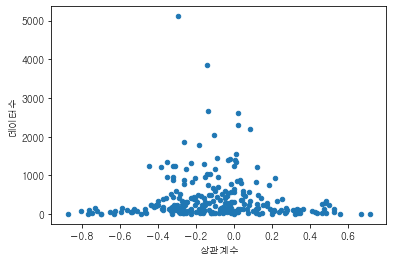

In [12]:
font_name = font_manager.FontProperties(fname="datas/fonts/gulim.ttc").get_name()
rc('font', family=font_name)

mask = use_df['건물주용도']=='연립주택'
corr_list = []
for station in use_df[mask].groupby('최단역명'):
    name = station[0]
    corr_val = station[1][['최단역거리', '면적당금액']].astype(np.float).corr()['면적당금액']['최단역거리']
    corr_list.append(
        {
            '전철역명':name,
            '상관계수':corr_val,
            '데이터수':len(station[1])
        }
    )
corr_df = pd.DataFrame(corr_list).sort_values(by='상관계수', axis=0)
corr_df = corr_df.dropna(subset=['상관계수'])
corr_df
corr_df.plot(kind='scatter', x='상관계수', y='데이터수')

# Map을 그리는 함수를 만들어 놓습니다

In [13]:
def draw_map(center, locations, values, qcut_colors,):
    map_ = folium.Map(center, zoom_start=14, tiles='Stamen Toner')
    colors = get_colors(values, qcut_colors)
    for (x,y),color in zip(locations.values, colors):
        folium.CircleMarker(
            location=[y, x],
            radius=4,
            color=color,
            fill_color=color,
            fill=True,
            fill_opacity=0.5,
        ).add_to(map_)
    folium.Marker(
        location=center,
        icon=folium.Icon(color='blue', icon='star'),
    ).add_to(map_)
    return map_

def get_colors(values, qcut_colors):
    colors = qcut_colors
    return pd.qcut(values, len(qcut_colors), labels=qcut_colors)


# 가좌역 부근 거래 정보를 시각화합니다
* 적당한 데이터수(1222개)를 가진 가좌역을 시각화합니다
* 가좌역의 상관계수는 -0.384 입니다
* 역에 가까울수록 비쌈을 의미합니다
* 빨간:고가, 주황:중간, 연두:저가

In [14]:
station = '가좌'
mask = (use_df['최단역명']==station)
cur_df = use_df[mask]
cur_df['면적당금액'] = cur_df['면적당금액'].astype(np.float)
cur_df = use_df[mask].sample(1000)
draw_map(
    center=xy_station.loc[xy_station['전철역명']==station, ['y', 'x']].values[0],
    locations=cur_df[['x', 'y']],
    values=cur_df['면적당금액'],
    qcut_colors=['lightgreen', 'orange', 'red']
)


C:\Users\Minji\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# 가좌역의 면적당금액과 거리와의 관계를 시각화합니다
* 상관계수에서 볼 수 있듯이 음의 상관관계를 보입니다

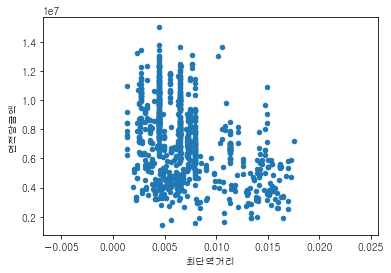

In [15]:
cur_df.plot(kind='scatter', x='최단역거리', y='면적당금액')

# 양의 상관관계를 가진 역의 원인을 추측합니다
* 시각화를 통해 원인을 찾아봅니다
* 0.475의 상관계수를 가지는 성수역을 시각화합니다
* 역에서 먼 한강부근에서의 집값이 높습니다
* 한강뷰(조망권)가 역세권보다 큰 영향을 준것으로 추측됩니다

In [16]:
station = '성수'
mask = (use_df['최단역명']==station)
cur_df['면적당금액'] = cur_df['면적당금액'].astype(np.float)
cur_df = use_df[mask]
draw_map(
    center=xy_station.loc[xy_station['전철역명']==station, ['y', 'x']].values[0],
    locations=cur_df[['x', 'y']],
    values=cur_df['면적당금액'],
    qcut_colors=['lightgreen', 'orange', 'red']
)